In [1]:
import matplotlib
from scipy.stats import poisson
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import trange 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class CarRental:
    def __init__(self,const_ret_cars = True):
        self.max_cars = 20
        self.max_move_cars = 5
        self.rent_req_loc1 = 3
        self.rent_req_loc2 = 3
        self.ret_loc1 = 3
        self.ret_loc2 = 2
        self.discount = 0.9
        self.rent_credit = 10
        self.move_car_cost = 2
        self.actions = np.arange(-self.max_move_cars, self.max_move_cars + 1)
        self.truncate = 11
        self.values = np.zeros((self.max_cars + 1, self.max_cars + 1))
        self.policy = np.zeros(self.values.shape, dtype=np.int)
        self.const_ret_cars = const_ret_cars
        self.poisson_prob_dict = dict()


    def compPoissonProb(self,n, lam):
        key = n * 10 + lam
        if key not in self.poisson_prob_dict:
            self.poisson_prob_dict[key] = poisson.pmf(n, lam)
        return self.poisson_prob_dict[key]

    def getValues(self):
        return self.values

    def getPolicy(self):
        return self.policy

    def solveBellman(self,state, action, state_value):

        returns = 0.0

        returns -=  self.move_car_cost* abs(action)


        for req_loc1 in range(self.truncate):
            for req_loc2 in range(self.truncate):

                prob = self.compPoissonProb(req_loc1, self.rent_req_loc1) * \
                    self.compPoissonProb(req_loc2, self.rent_req_loc2)

                num_cars_loc1, num_cars_loc2 = min(state[0] - action, self.max_cars), min(state[1] + action, self.max_cars)

                rental_loc1, rental_loc2 = min(num_cars_loc1, req_loc1), min(num_cars_loc2, req_loc2)


                reward = (rental_loc1 + rental_loc2) * self.rent_credit
                
                num_cars_loc1 -= rental_loc1
                num_cars_loc2 -= rental_loc2

                if self.const_ret_cars:
                    ret_cars_loc1, ret_cars_loc2 = self.ret_loc1, self.ret_loc2
                    num_cars_loc1, num_cars_loc2 = min(num_cars_loc1 + ret_cars_loc1, self.max_cars), min(num_cars_loc2 + ret_cars_loc2, self.max_cars)
                    returns += prob * (reward + self.discount * state_value[num_cars_loc1, num_cars_loc2])
                else:
                    for ret_cars_loc1 in range(self.truncate):
                        for ret_cars_loc2 in range(self.truncate):
                            prob_return = self.compPoissonProb(
                                ret_cars_loc1, self.ret_loc1) * self.compPoissonProb(ret_cars_loc2, self.ret_loc2)
                            num_cars_loc1_ret, num_cars_loc2_ret = min(num_cars_loc1 + ret_cars_loc1, self.max_cars), min(num_cars_loc2 + ret_cars_loc2, self.max_cars)
                            prob_ret = prob_return * prob
                            returns += prob_ret * (reward + self.discount * state_value[num_cars_loc1_ret, num_cars_loc2_ret])
        return returns


    def policyEvaluation(self,value,policy):
        while True:
                old_value = value.copy()
                for i in range(self.max_cars + 1):
                    for j in range(self.max_cars + 1):
                        new_state_value = self.solveBellman([i, j], policy[i, j], value)
                        value[i, j] = new_state_value
                max_delta = abs(old_value - value).max()
                print(f'max delta : {max_delta}')
                if max_delta < 1e-4:
                    break

        return value 

    def policyImprovement(self,policy,value):
        policy_stable = True
        for i in range(self.max_cars + 1):
            for j in range(self.max_cars + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in self.actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(self.solveBellman([i, j], action, value))
                    else:
                        action_returns.append(-np.inf)
                new_action = self.actions[np.argmax(action_returns)]
                policy[i, j] = new_action
                if policy_stable and old_action != new_action:
                    policy_stable = False
        print(f'policy stable {policy_stable}')
        return policy, policy_stable


    def figure_4_2(self):
        iter_cnt = 0
        
        _, axes = plt.subplots(2, 3, figsize=(40, 20))
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        axes = axes.flatten()
        
        while True:
            fig = sns.heatmap(np.flipud(self.policy), cmap="YlGnBu", ax=axes[iter_cnt])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(self.max_cars + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('policy {}'.format(iter_cnt), fontsize=30)

            self.values = self.policyEvaluation(self.values,self.policy)

            # policy improvement
            self.policy, policy_stable = self.policyImprovement(self.policy,self.values)

            if policy_stable:
                fig = sns.heatmap(np.flipud(self.values), cmap="YlGnBu", ax=axes[-1])
                fig.set_ylabel('# cars at first location', fontsize=30)
                fig.set_yticks(list(reversed(range(self.max_cars + 1))))
                fig.set_xlabel('# cars at second location', fontsize=30)
                fig.set_title('optimal value', fontsize=30)
                break

            iter_cnt += 1
        print('iterations:',iter_cnt+1)
        #plt.savefig('../images/figure_4_2.png')
        #plt.close()
        plt.show()



In [3]:
def plot3dValues(values):
    x = np.arange(21)
    y = np.arange(21)
    x,y = np.meshgrid(x,y)
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x,y,values,rstride=1,cstride=1,cmap='hot',linewidth=0,antialiased=False)
    ax.set_xlabel('# cars at location 1')
    ax.set_ylabel('# cars at location 2')
    ax.set_title('Optimal Value')
    fig.colorbar(surf,shrink = 0.5, aspect = 5)
    plt.show()

max delta : 140.60068276451554
max delta : 103.25877249659266
max delta : 79.54555567437669
max delta : 62.45772254224954
max delta : 50.669837686516416
max delta : 42.36952738188012
max delta : 35.008148822699184
max delta : 28.708337982268745
max delta : 23.449798881011247
max delta : 20.06374287814708
max delta : 17.30261307783053
max delta : 14.888360048625827
max delta : 12.78895633883775
max delta : 10.970520166501274
max delta : 9.40000639626021
max delta : 8.04657697818243
max delta : 6.882213227553052
max delta : 5.88188779828738
max delta : 5.023491432037872
max delta : 4.287635230543287
max delta : 3.6574002804696306
max delta : 3.1180748273381482
max delta : 2.6568998622143454
max delta : 2.262832871020919
max delta : 1.9263334585830307
max delta : 1.6391714512848239
max delta : 1.394256576824489
max delta : 1.1854881556188275
max delta : 1.0076230016003365
max delta : 0.8561597035752015
max delta : 0.7272375314767601
max delta : 0.6175483294055653
max delta : 0.52425989189

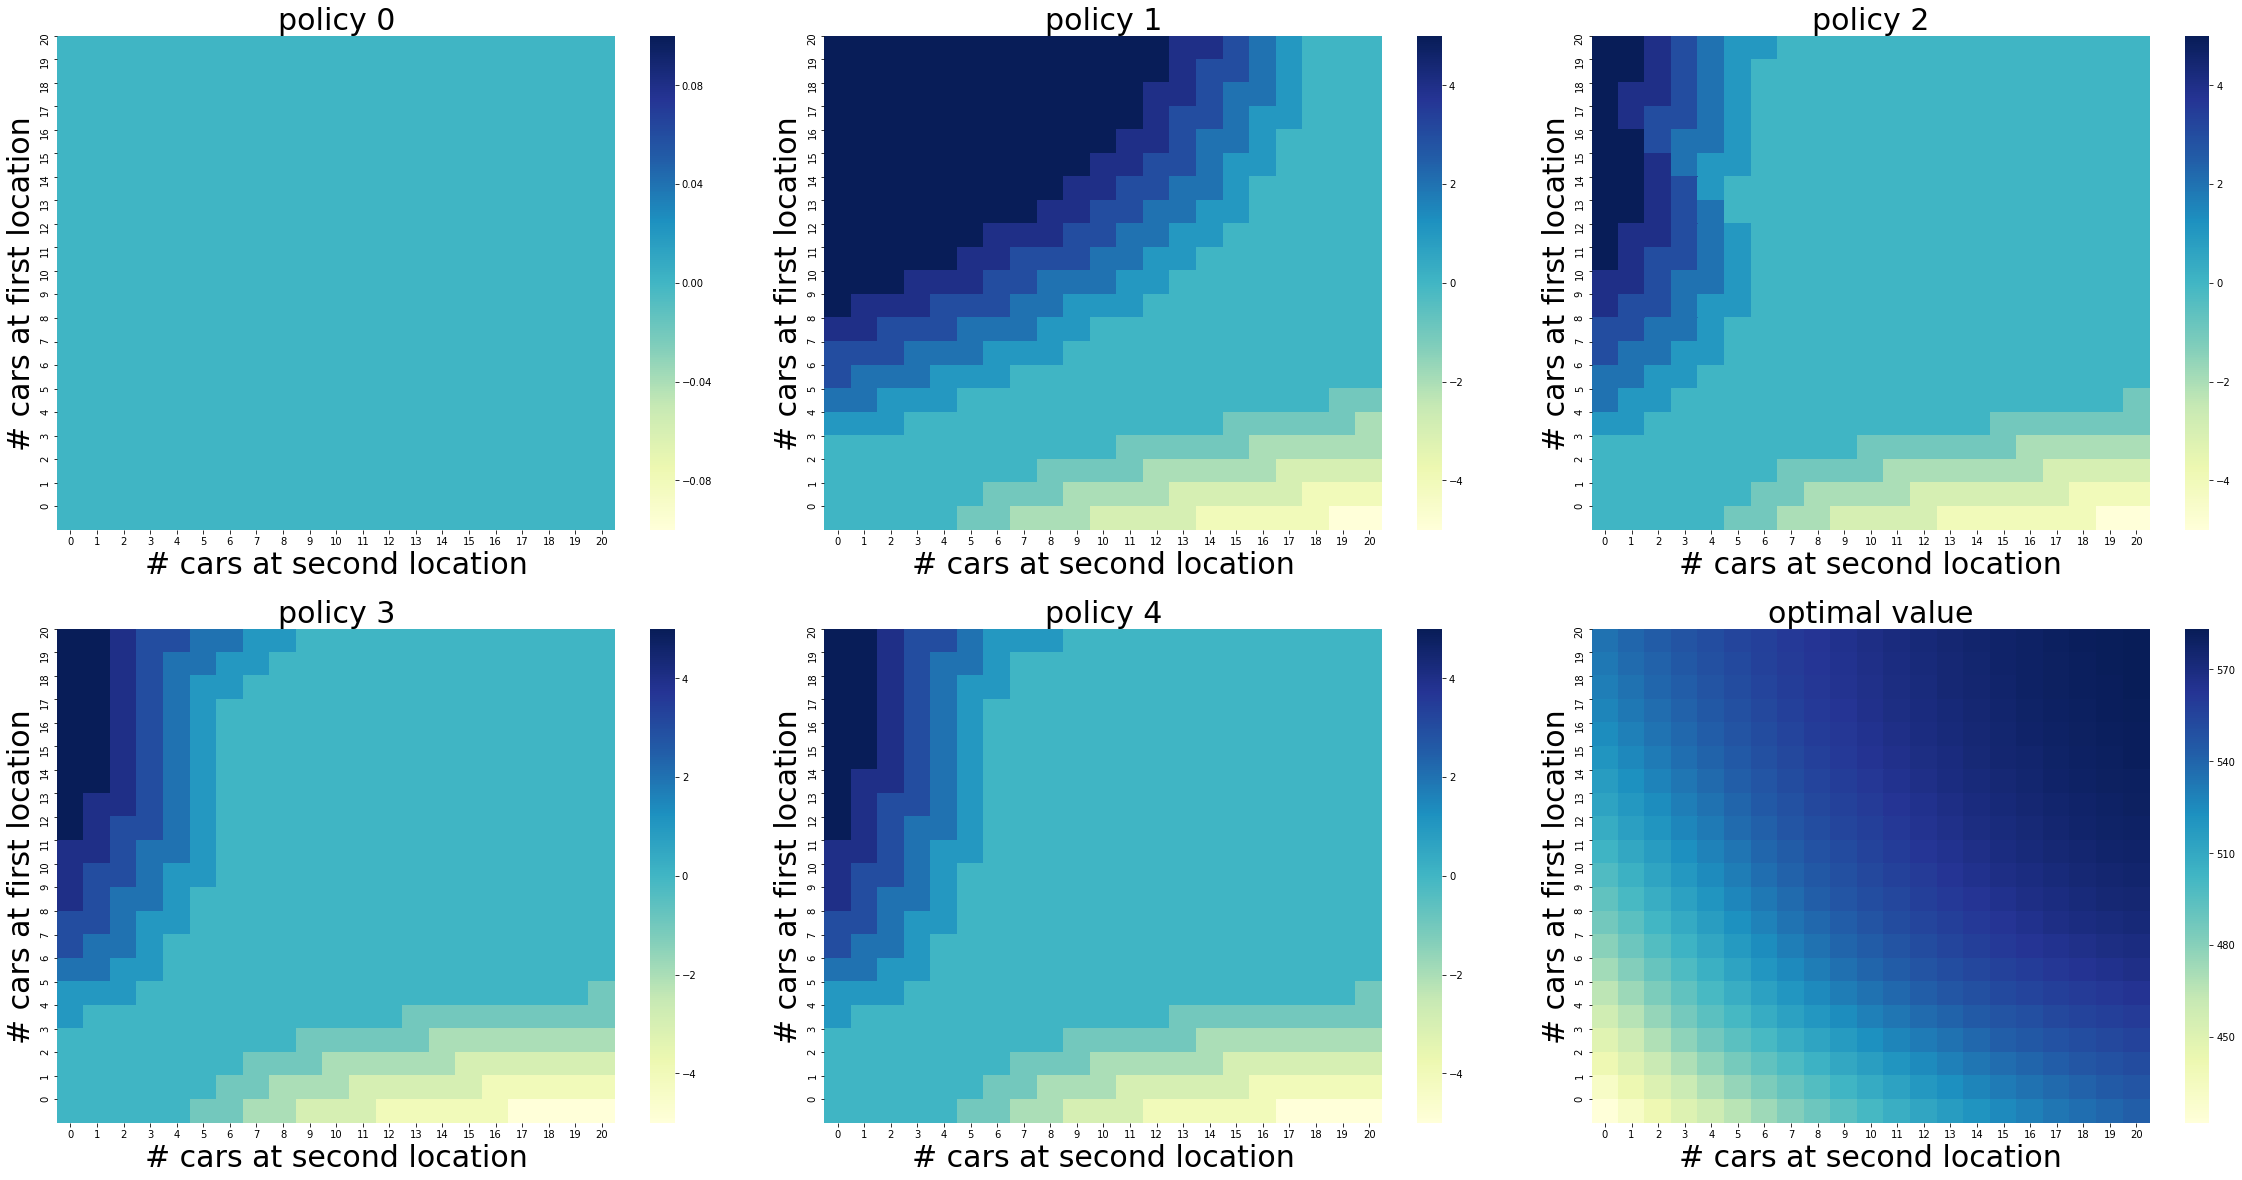

In [4]:
car = CarRental()
car.figure_4_2()


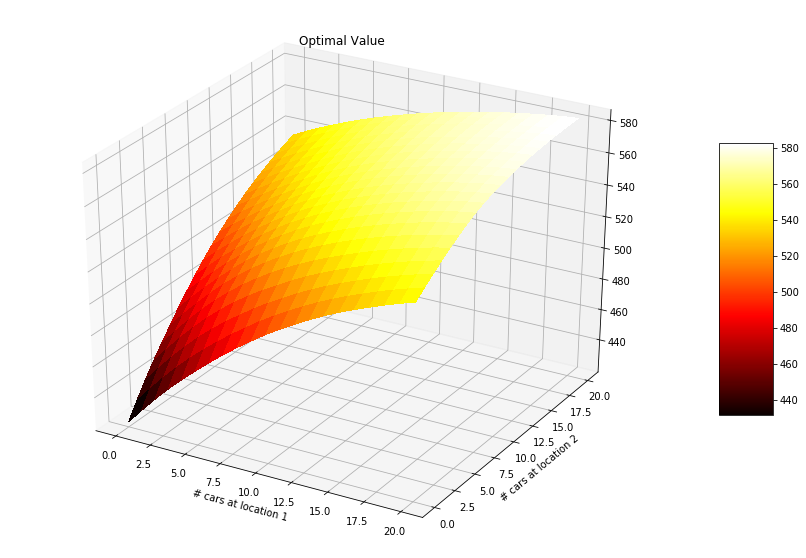

In [5]:
values = car.getValues()
plot3dValues(values)

In [ ]:
car = CarRental(const_ret_cars = False)
car.figure_4_2()

max delta : 146.31907965465376
max delta : 106.72793660593628
max delta : 79.82121997711641
max delta : 61.43059945111179
max delta : 50.230717359520156
max delta : 41.811864927685974
max delta : 34.39409550502455
max delta : 28.132754369492318
max delta : 22.961125921167422
max delta : 18.733420628197678
max delta : 15.292665969941652
max delta : 12.695019984021258
max delta : 10.591310406632886
max delta : 8.816756964877925
max delta : 7.324995927116049
max delta : 6.0749160957258255
max delta : 5.030346541329209
max delta : 4.159714277279818
max delta : 3.435674856638343
max delta : 2.834719394634078
max delta : 2.3367699080568514
max delta : 1.924777998043396
max delta : 1.5843403059129741
